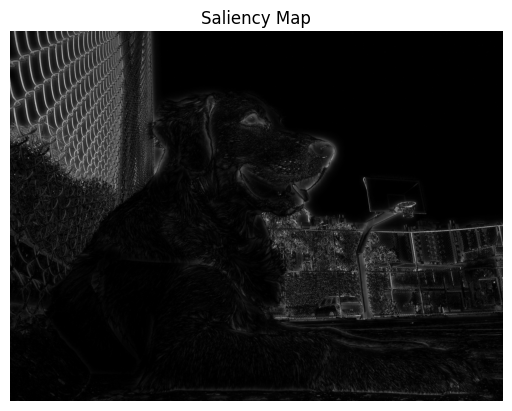

In [ ]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('/content/IMG_20220103_090849.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

saliency = cv2.saliency.StaticSaliencyFineGrained_create()
(success, saliency_map) = saliency.computeSaliency(image)

plt.imshow(saliency_map, cmap='gray')
plt.title('Saliency Map')
plt.axis('off')
plt.show()


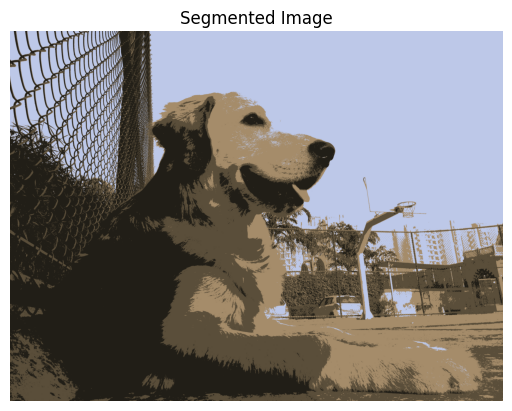

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

image = cv2.imread('/content/IMG_20220103_090849.jpg')
Z = image.reshape((-1, 3))
Z = np.float32(Z)

kmeans = KMeans(n_clusters=4, random_state=0).fit(Z)
centers = np.uint8(kmeans.cluster_centers_)
labels = kmeans.labels_

segmented_image = centers[labels.flatten()].reshape(image.shape)

plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title('Segmented Image')
plt.axis('off')
plt.show()


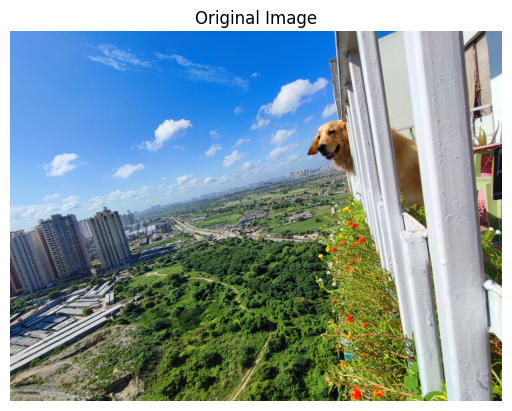

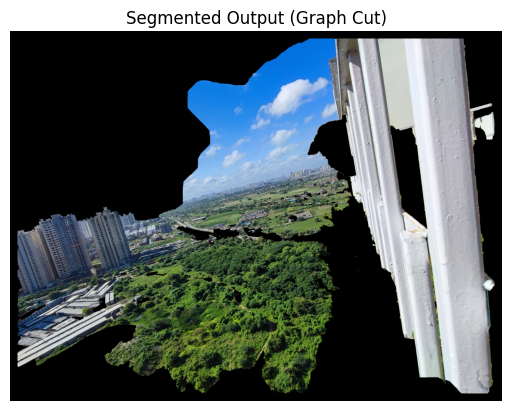

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image = cv2.imread('/content/IMG_20240927_094747.jpg')
if image is None:
    raise ValueError("Image not found or not uploaded correctly!")

# Show original
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')
plt.show()

# Create mask
mask = np.zeros(image.shape[:2], np.uint8)

# Create temporary arrays used by grabCut (needed by the algorithm)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# Define a rectangle around the object you want to segment (x, y, w, h)
# Example: around a flower, a face, etc.
rect = (50, 50, image.shape[1] - 100, image.shape[0] - 100)  # Adjust accordingly!

# Apply grabCut
cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# Modify mask to extract the foreground
segmentation_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
result = image * segmentation_mask[:, :, np.newaxis]

# Show result
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Segmented Output (Graph Cut)")
plt.axis('off')
plt.show()


In [ ]:
# STEP 1: Download the dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
!apt install unrar
!unrar x UCF101.rar

# STEP 2: Install OpenCV
!pip install opencv-python-headless

# STEP 3: Import libraries
import os
import cv2
import numpy as np

# STEP 4: Preprocessing function
def preprocess_video(video_path, size=(64, 64), frames=16):
    cap = cv2.VideoCapture(video_path)
    frames_list = []
    while len(frames_list) < frames:
        ret, frame = cap.read()
        if not ret:
            break
        resized = cv2.resize(frame, size)
        frames_list.append(resized)
    cap.release()

    if not frames_list:
        raise ValueError(f"No frames found in video: {video_path}")

    while len(frames_list) < frames:
        frames_list.append(np.zeros_like(frames_list[0]))

    video_array = np.array(frames_list)
    return video_array[:frames] / 255.0

# STEP 5: Example usage
video_path = 'UCF-101/JumpingJack/v_JumpingJack_g01_c01.avi'
video_tensor = preprocess_video(video_path)
print("Shape:", video_tensor.shape)


Streaming output truncated to the last 5000 lines.
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c01.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c02.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c03.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c04.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c05.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c06.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c07.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g08_c01.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g08_c02.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g08_c03.avi             62%  OK 
Extracting  UCF-101/PlayingGu

In [ ]:
import torch
import torch.nn as nn

class SimpleVideoGenerator(nn.Module):
    def __init__(self, z_dim=100, channels=3, frames=16):
        super().__init__()
        self.frames = frames
        self.generator_frame = nn.Sequential(
            nn.Linear(z_dim, 128 * 8 * 8),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(128, 8, 8)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 64x16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(64, channels, 4, stride=2, padding=1),  # 3x32x32
            nn.Tanh()
        )

    def forward(self, z):
        b = z.size(0)
        # Generate one frame per z, repeated for all frames (same video repeated)
        frames = [self.generator_frame(z) for _ in range(self.frames)]
        video = torch.stack(frames, dim=1)  # (B, T, C, H, W)
        return video

# Test
generator = SimpleVideoGenerator()
z = torch.randn(2, 100)  # 2 samples in the batch
fake_videos = generator(z)
print(fake_videos.shape)  # (2, 16, 3, 32, 32)


torch.Size([2, 16, 3, 32, 32])
